# Train the Model

## Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from models import Encoder, Decoder

from pathlib import Path
from DatasetInterface import MSCOCOInterface
from data_prep_utils import *
import json
import numpy as np
import time

###### download the data we need
# !cd ~/INM706-image-captioning/Datasets/coco/images/
# !wget http://images.cocodataset.org/zips/train2017.zip
# !wget http://images.cocodataset.org/zips/val2017.zip
# !unzip train2017.zip
# !unzip val2017.zip
# !rm train2017.zip
# !rm val2017.zip

##### run code below if nltk hasn't been set up in clound instance yet
# !python -m nltk.downloader -d /usr/local/share/nltk_data all

###### run code below to save pre-trained weights if needed
# cd ~/INM706-image-captioning/model
# !wget https://download.pytorch.org/models/resnet152-394f9c45.pth
# !mv resnet152-394f9c45.pth resnet152_model.pth

## Load Dataset Interface and DataLoader

In [15]:
#########
# paths for Khalil
#########
# root = Path('Data')

#captions_path = root/'annotations'/'captions_train2017.json'

# train_captions_path = root/'annotations_trainval2017'/'annotations'/'sports_captions_train.json'
# val_captions_path = root/'annotations_trainval2017'/'annotations'/'sports_captions_val.json'
# test_captions_path = root/'annotations_trainval2017'/'annotations'/'sports_captions_test.json'

#########
# paths for Alex
#########

root = Path('Datasets/coco')
imgs_path = root/'images'/'train2017'
imgs_path_test = root/'images'/'val2017'

prepare_datasets(train_percent = 0.87, super_categories=['sports'],
                    max_train=15000, max_val=3000, max_test=3000)

train_captions_path = root/'annotations'/'sports_captions_train.json'
val_captions_path = root/'annotations'/'sports_captions_val.json'
test_captions_path = root/'annotations'/'sports_captions_test.json'

#### build vocab using full original coco train
build_vocab(freq_threshold=2, sequence_length=40,
            captions_file=['captions_train2017.json'])
# load vocab
with open('vocabulary/idx_to_string.json') as json_file:
    idx_to_string_json = json.load(json_file)
        
idx_to_string = dict()
for key in idx_to_string_json:
    idx_to_string[int(key)] = idx_to_string_json[key]
    
with open('vocabulary/string_to_index.json') as json_file:
    string_to_index = json.load(json_file)


train dataset has 15000 images
 val dataset has 3000 images
 test dataset has 938 images
There are 591753 captions in the data set
With FREQ_THRESHOLD = 2, vocab size is 16232


In [16]:
root = Path('Datasets/coco')
imgs_path = root/'images'/'train2017'
imgs_path_test = root/'images'/'val2017'

train_captions_path = root/'annotations'/'sports_captions_train.json'
val_captions_path = root/'annotations'/'sports_captions_val.json'
test_captions_path = root/'annotations'/'sports_captions_test.json'

# load vocab
with open('vocabulary/idx_to_string.json') as json_file:
    idx_to_string_json = json.load(json_file)
        
idx_to_string = dict()
for key in idx_to_string_json:
    idx_to_string[int(key)] = idx_to_string_json[key]
    
with open('vocabulary/string_to_index.json') as json_file:
    string_to_index = json.load(json_file)

In [17]:
# to boost the performence of CUDA use:
# torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
train_interface_params = {
    'imgs_path': imgs_path,
    'captions_path': train_captions_path,
    'freq_threshold': 5,
    'sequence_length': 20,
    'caps_per_img': 3,
    'stage': "train",
    'idx_to_string': idx_to_string,
    'string_to_index': string_to_index,
}

val_interface_params = {
    'imgs_path': imgs_path,
    'captions_path': val_captions_path,
    'freq_threshold': 5,
    'sequence_length': 20,
    'caps_per_img': 3,
    'stage': "validation",
    'idx_to_string': idx_to_string,
    'string_to_index': string_to_index,
}

test_interface_params = {
    'imgs_path': imgs_path_test,
    'captions_path': test_captions_path,
    'freq_threshold': 5,
    'sequence_length': 20,
    'caps_per_img': 3,
    'stage': "test",
    'idx_to_string': idx_to_string,
    'string_to_index': string_to_index,
}


# Training Interface
coco_interface_train = MSCOCOInterface(**train_interface_params)

# Validation Interface
coco_interface_val = MSCOCOInterface(**val_interface_params)

# Testing Interface
coco_interface_test = MSCOCOInterface(**test_interface_params)


In [19]:
print("Lenght of training image: {}, Lenght of Validation image: {} Lenght of Testing image: {}"\
      .format(len(coco_interface_train), len(coco_interface_val), len(coco_interface_test)))

print(f"Length of vocabulary: {len(coco_interface_train.idx_to_string)}")

Lenght of training image: 45000, Lenght of Validation image: 9000 Lenght of Testing image: 2814
Length of vocabulary: 16232


In [31]:
batch_size = 32
train_loader = data.DataLoader(coco_interface_train, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(coco_interface_val, batch_size=batch_size, shuffle=False)
test_loader = data.DataLoader(coco_interface_test, batch_size=batch_size, shuffle=False)

## Parameters

In [32]:
embed_size = 512
hidden_size = 512
vocab_size = len(coco_interface_train.idx_to_string)
num_layers = 1

## Encoder and Decoder

In [33]:
encoder = Encoder(embed_size=embed_size, pretrained=False, model_weight_path="./model/resnet152_model.pth")
decoder = Decoder(embed_size=embed_size, hidden_size=hidden_size, vocab_size=vocab_size, num_layers=num_layers)
print("########################################READY########################################")

########################################READY########################################


In [34]:
# the loss is a cross entropy loss and ignore the index of <PAD> since it doesn't make any difference
criterion = nn.CrossEntropyLoss(ignore_index=coco_interface_train.string_to_index["<PAD>"])

# combine the paramters of decoder and ecnoder
params = list(decoder.parameters()) + list(encoder.embed.parameters())

# Adam optimizer
opt_pars = {'lr':1e-5, 'weight_decay':1e-3, 'betas':(0.9, 0.999), 'eps':1e-08}
optimizer = optim.Adam(params, **opt_pars)

## Train

In [35]:
def save_model(epoch, encoder, decoder, training_loss, validation_loss, checkpoint_path):
    torch.save({
        'epoch': epoch,
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'training_loss': training_loss,
        'validation_loss': validation_loss
    }, checkpoint_path)

def load_model(encoder, decoder, checkpoint_path):

    checkpoint = torch.load(checkpoint_path)
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    training_loss = checkpoint['training_loss']
    validation_loss = checkpoint['validation_loss']

    return encoder, decoder, training_loss, validation_loss


In [104]:
CHECKPOINT = './model/image_captioning_model_v4.pth'
if Path(CHECKPOINT).exists():
    encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)
else:
    print(f'{CHECKPOINT} file does not exist, training startging from scratch')

In [105]:
for i, batch in enumerate(val_loader):
    idx, images, captions = batch
    images, captions = images.to(device), captions.to(device)
    features = encoder(images)
    outputs = decoder(features, captions)
    loss = criterion(outputs.view(-1, vocab_size), captions.contiguous().view(-1))
    val_epoch_loss += loss.item()

KeyboardInterrupt: 

In [106]:
encoder.to(device)
decoder.to(device)
encoder.eval()
decoder.eval()

val_epoch_loss = 0
for i, batch in enumerate(val_loader):
    idx, images, captions = batch
    images, captions = images.to(device), captions.to(device)
    features = encoder(images)
    outputs = decoder(features, captions)
    loss = criterion(outputs.view(-1, vocab_size), captions.contiguous().view(-1))
    val_epoch_loss += loss.item()
    if i % 100 == 0:
        print('Validation: ', i, ' ', loss.item())

val_epoch_loss /= len(val_loader)
validation_loss.append(val_epoch_loss)
    
        
print("Validation Loss: {:.4f}, Validation Perplexity: {:.4f}."
      .format(val_epoch_loss, np.exp(val_epoch_loss)))
          
# random image:

    

Validation:  0   2.4801230430603027
Validation:  100   2.296351909637451
Validation:  200   2.365896701812744
Validation Loss: 2.5361, Validation Perplexity: 12.6303.


In [112]:
for i, batch in enumerate(train_loader):
    idx, images, captions = batch
    images, captions = images.to(device), captions.to(device)
    if i == 0: break
# decoder.get_predict(encoder(images), 20)
encoder(images).shape


torch.Size([32, 512])

In [113]:
for i in range(32):
    im = images[i]
    features = encoder(im.unsqueeze(0).to(device))
    pred = decoder.get_predict(features, 20)

    print(' '.join([coco_interface_val.idx_to_string[int(word.item())] 
              for word in list(pred.squeeze(0))]))

<SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a
<SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a
<SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a
<SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a
<SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a
<SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a
<SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a
<SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a
<SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a
<SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a
<SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a
<SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a
<SOS> a <SOS> a <SOS> a <SOS> a <SOS> a 

In [109]:
features = encoder(images)
for i in range(1):
    hiddens, states = decoder.lstm(features.unsqueeze(0))
    outputs = decoder.linear(hiddens)
    _, predicted = outputs.max(1)
predicted.shape, outputs.shape

(torch.Size([1, 16232]), torch.Size([1, 32, 16232]))

In [100]:
idx, im, cap = coco_interface_val.__getitem__(410)
im = images
# features = encoder(im.unsqueeze(0).to(device))
pred = decoder.get_predict(features, 20)
print("im shape: {}\nim.unsqueeze(0) shape: {}\nfeatures shape: {}"
      .format(im.shape, im.unsqueeze(0).shape, features.shape))
inputs = features.unsqueeze(0)
hiddens, states = decoder.lstm(inputs)
print('hiddens shape: {}\nstates size: {}\n states[0] shape: {}\n states[1] shape: {}'
      .format(hiddens.shape, len(states), states[0].shape, states[1].shape))
print('hiddens.squeeze(1) shape: {}'.format(hiddens.squeeze(1).shape))
outputs = decoder.linear(hiddens.squeeze(1))
print('outputs shape: {}'.format(outputs.shape))
_, predicted = outputs.max(1)
print('predicted shape: {}'.format(predicted.shape))
print(outputs[:, :10])
print('embed(predicted).shape: {}'.format(decoder.embed(predicted).shape))
# decoder.embed(predicted).shape

im shape: torch.Size([32, 3, 400, 400])
im.unsqueeze(0) shape: torch.Size([1, 32, 3, 400, 400])
features shape: torch.Size([1, 512])
hiddens shape: torch.Size([1, 1, 512])
states size: 2
 states[0] shape: torch.Size([1, 1, 512])
 states[1] shape: torch.Size([1, 1, 512])
hiddens.squeeze(1) shape: torch.Size([1, 512])
outputs shape: torch.Size([1, 16232])
predicted shape: torch.Size([1])
tensor([[-0.2368, 18.0953, -0.1342,  2.5007,  6.9185,  1.2658, -0.1668,  2.6483,
          0.6816,  1.4361]], device='cuda:0', grad_fn=<SliceBackward0>)
embed(predicted).shape: torch.Size([1, 512])


In [59]:
idx, im, cap = coco_interface_val.__getitem__(410)
features = encoder(im.unsqueeze(0).to(device))
pred = decoder.get_predict(features, 20)

pred.shape
' '.join([coco_interface_val.idx_to_string[int(word.item())] 
          for word in list(pred.squeeze(0))])

'<SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a <SOS> a'

In [57]:
pred.squeeze(0).shape

torch.Size([20])

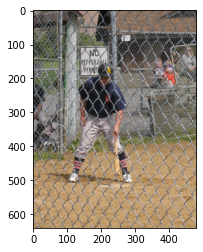

'<SOS> a boy holding a baseball bat is up to bat <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

In [51]:
coco_interface_val.display_img_with_captions(400)

' '.join([coco_interface_val.idx_to_string[word.item()] 
          for word in list(cap)])

In [15]:
def train(encoder, decoder, criterion, optimizer, train_loader, val_loader, total_epoch, checkpoint_path):
    
    encoder.to(device)
    decoder.to(device)
    
    training_loss = []
    validation_loss = []
    
    start_time = time.time()
    for epoch in range(total_epoch):
        train_epoch_loss = 0
        val_epoch_loss = 0
        
        
        # Training phase
        encoder.train()
        decoder.train()
        
        for i, batch in enumerate(train_loader):
            idx, images, captions = batch
            images, captions = images.to(device), captions.to(device)
            
            # Zero the gradients.
            encoder.zero_grad()
            decoder.zero_grad()
            
            features = encoder(images)
            outputs = decoder(features, captions)
            
            loss = criterion(outputs.view(-1, vocab_size), captions.contiguous().view(-1))
            
            loss.backward()
            optimizer.step()
        
            train_epoch_loss += loss.item()
            if i % 100 == 0:
                print('Training: ', i, ' ', loss.item())
                
        train_epoch_loss /= len(train_loader)
        training_loss.append(train_epoch_loss)
        
        # validation phase
        encoder.eval()
        decoder.eval()
        
        for i, batch in enumerate(val_loader):
            idx, images, captions = batch
            images, captions = images.to(device), captions.to(device)
            features = encoder(images)
            outputs = decoder(features, captions)
            loss = criterion(outputs.view(-1, vocab_size), captions.contiguous().view(-1))
            val_epoch_loss += loss.item()
            if i % 100 == 0:
                print('Validation: ', i, ' ', loss.item())
            
        val_epoch_loss /= len(val_loader)
        validation_loss.append(val_epoch_loss)
    
        epoch_time = (time.time() - start_time) /60**1

        save_model(epoch, encoder, decoder, training_loss, validation_loss, checkpoint_path)

        print("Epoch: {:d}. Training Loss = {:.4f}, Training Perplexity: {:.4f}. Validation Loss: {:.4f}, Validation Perplexity: {:.4f}. Time: {:f}" \
          .format(epoch, train_epoch_loss, np.exp(train_epoch_loss), val_epoch_loss, np.exp(val_epoch_loss), epoch_time))
    
    return training_loss, validation_loss
    

In [ ]:
train_params = {
    'encoder': encoder,
    'decoder': decoder,
    'criterion': criterion,
    'optimizer': optimizer,
    'train_loader': train_loader,
    'val_loader': val_loader,
    'total_epoch': 100,
    'checkpoint_path': CHECKPOINT
}

training_loss, validation_loss = train(**train_params) 

Training:  0   9.515953063964844
Training:  100   9.210984230041504
Training:  200   8.009066581726074
Training:  300   6.2172160148620605
Training:  400   5.627791404724121
Training:  500   5.186134338378906
Training:  600   4.789130210876465
Training:  700   4.47951078414917
Training:  800   4.59299898147583
Training:  900   4.52008581161499
Training:  1000   4.329635143280029
Training:  1100   4.214908599853516
Training:  1200   4.064572334289551
Training:  1300   4.279685020446777
Training:  1400   4.430614948272705
Validation:  0   4.184030055999756
Validation:  100   4.056313991546631
Validation:  200   4.125290870666504
Epoch: 0. Training Loss = 5.4922, Training Perplexity: 242.7841. Validation Loss: 4.2283, Validation Perplexity: 68.6030. Time: 19.891358
Training:  0   4.340602874755859
Training:  100   4.150339126586914
Training:  200   4.1194915771484375
Training:  300   4.195537567138672
Training:  400   4.215137004852295
Training:  500   4.233678817749023
Training:  600   3